# Coarse-graining tendency terms
CESM

In [28]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(15)
client = cluster.get_client()

In [3]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [4]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.7c092a18e5d64467afa186dfacdebb8b/status,


In [116]:
client.close()
cluster.close()

In [5]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import json
import fsspec
import gcsfs
import gcm_filters
import pop_tools

In [6]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
cesm  = cat["CESM_POP_hires_control"].to_dask()
#workaround from Julius to make gradient func work quicker
ds_drop = cesm.drop([v for v in cesm.coords if v not in ['DXT', 'DXU', 'DYT', 'DYU', 'KMT', 'TAREA',
                                                         'HUS', 'HTE','HTN', 'HUW', 'time']])

In [7]:
#Load in tendencies

import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

tracers = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tracer_tendencies_40yr.zarr'))
drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/drhodts_tendencies_40yr.zarr'))
rho_cab = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/rho_bih_cab_tendencies_40yr.zarr'))

tendencies = xr.merge([tracers, drhodts, rho_cab])

In [8]:
#New ds after dthetadt*drhodt and dSdt*drhods
def new_ds(ds):
    newds = xr.merge([(ds['SST_bih']*ds['drhodt']).rename('sst'),
                      (ds['SSS_bih']*ds['drhods']).rename('sss'),
                       ds['rho_bih'].rename('rho'),
                       ds['cabbeling']])
    return newds

In [9]:
tend = new_ds(tendencies)

In [10]:
tend

<xarray.Dataset>
Dimensions:    (nlat: 2400, nlon: 3600, time: 14965)
Coordinates:
  * nlat       (nlat) int64 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon       (nlon) int64 0 1 2 3 4 5 6 ... 3593 3594 3595 3596 3597 3598 3599
  * time       (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Data variables:
    sst        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    sss        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

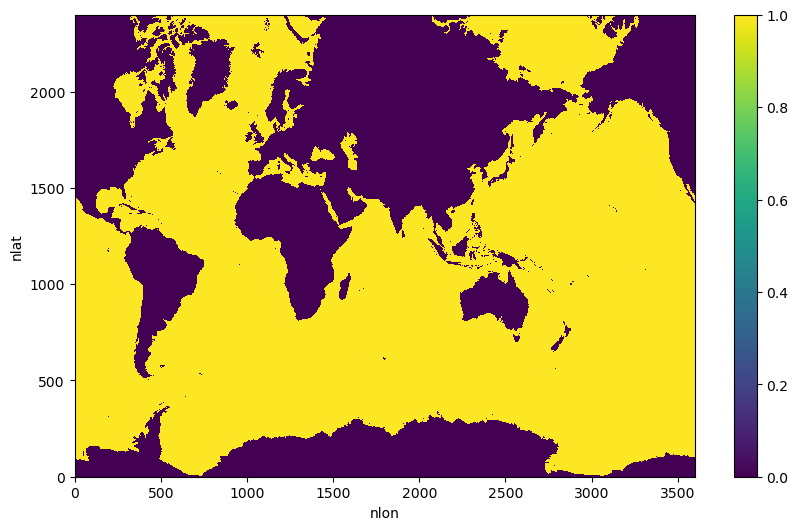

In [11]:
gcm_filters.required_grid_vars(gcm_filters.GridType.TRIPOLAR_POP_WITH_LAND)
wet_mask = xr.where(ds_drop['KMT']>0, 1, 0)
wet_mask.plot(figsize=(10,6), cbar_kwargs={'label': ''});

In [12]:
area = ds_drop.TAREA  # in cm^2
dxe = ds_drop.HUS  # x-spacing centered at eastern T-cell edge in cm
dye = ds_drop.HTE  # y-spacing centered at eastern T-cell edge in cm
dxn = ds_drop.HTN  # x-spacing centered at northern T-cell edge in cm
dyn = ds_drop.HUW  # y-spacing centered at northern T-cell edge in cm

In [13]:
# Didn't need .values for each direction previously, but I seem to now (otherwise I get NaN)
dx_min_POP = min(dxe.where(wet_mask).min().values, dye.where(wet_mask).min().values, 
                 dxn.where(wet_mask).min().values, dyn.where(wet_mask).min().values)
dx_min_POP 

array(224578.30434359)

## 100km 

In [14]:
specs_100km = {'filter_scale': 10000000, # 100km filter scale (written in cm to match model output)
         'filter_shape': gcm_filters.FilterShape.GAUSSIAN, 'dx_min': dx_min_POP}

In [15]:
filter_tripolar_pop_with_land_100km = gcm_filters.Filter(**specs_100km, 
                                                   grid_type=gcm_filters.GridType.TRIPOLAR_POP_WITH_LAND,
                                                   grid_vars={'wet_mask': wet_mask, 'dxe': dxe, 'dye': dye, 
                                                              'dxn': dxn, 'dyn': dyn, 'tarea': area})
filter_tripolar_pop_with_land_100km

Filter(filter_scale=10000000, dx_min=array(224578.30434359), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=49, grid_type=<GridType.TRIPOLAR_POP_WITH_LAND: 9>)

In [16]:
filtered100km_sst = filter_tripolar_pop_with_land_100km.apply(tend.sst, dims=['nlat', 'nlon'])
filtered100km_sss = filter_tripolar_pop_with_land_100km.apply(tend.sss, dims=['nlat', 'nlon'])
filtered100km_rho = filter_tripolar_pop_with_land_100km.apply(tend.rho, dims=['nlat', 'nlon'])
filtered100km_cab = filter_tripolar_pop_with_land_100km.apply(tend.cabbeling, dims=['nlat', 'nlon'])

In [22]:
sst_100km = filtered100km_sst[0].compute()
sss_100km = filtered100km_sss[0].compute()

rho_100km = filtered100km_rho[0].compute()
cab_100km = filtered100km_cab[0].compute()

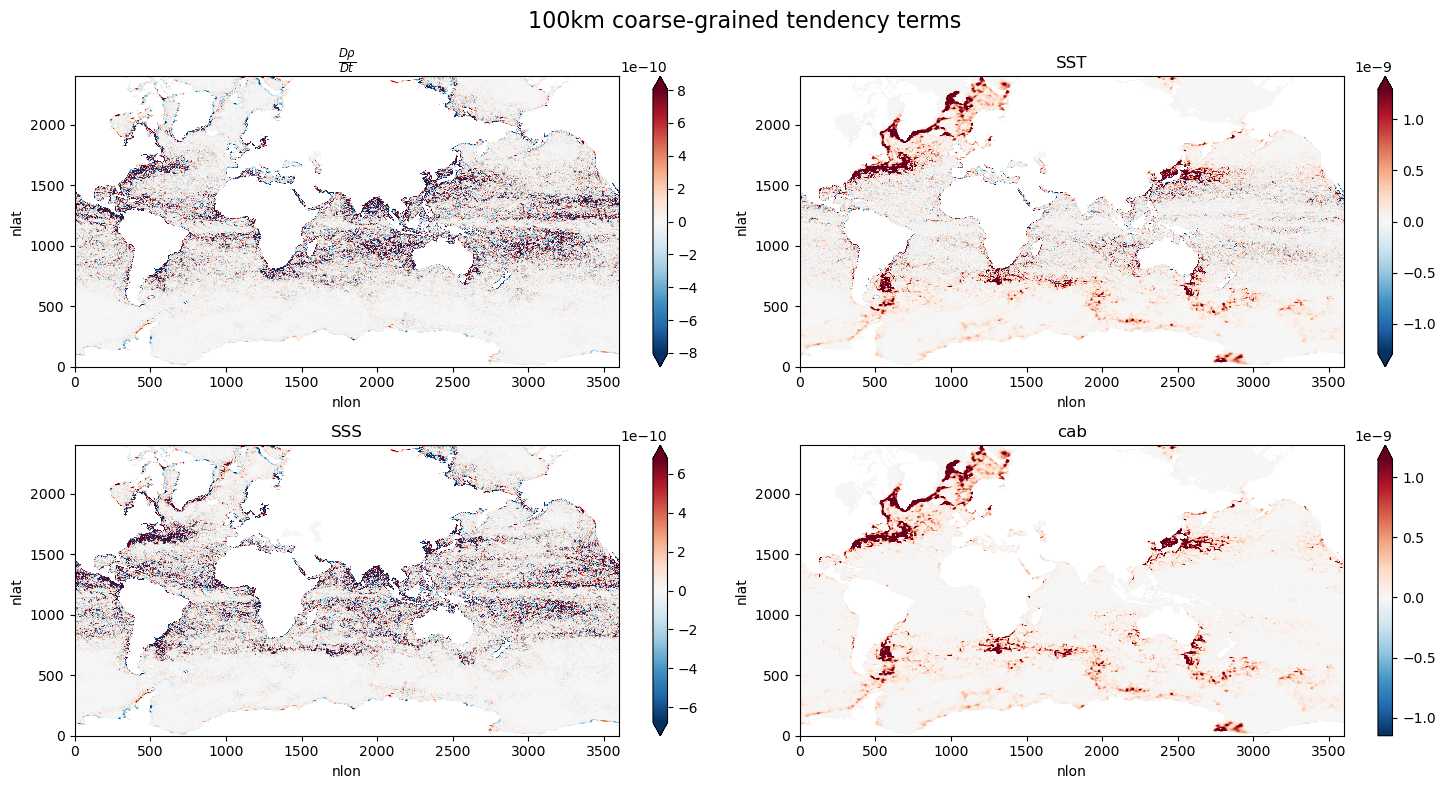

In [27]:
fig, ax = plt.subplots(2,2, figsize=(15,8))

rho_100km.plot(ax=ax[0,0], robust=True)
ax[0,0].set_title(r'$\frac{D \rho}{D t}$')

sst_100km.plot(ax=ax[0,1], robust=True)
ax[0,1].set_title('SST')

sss_100km.plot(ax=ax[1,0], robust=True)
ax[1,0].set_title('SSS')

cab_100km.plot(ax=ax[1,1], robust=True)
ax[1,1].set_title('cab')

plt.suptitle('100km coarse-grained tendency terms', fontsize=16)
plt.tight_layout();

## Plot NATL Region

In [17]:
mask = cesm.REGION_MASK.reset_coords(drop=True)

In [18]:
#assign each region index value to basin name

caspian_sea = -14
black_sea = -13
#unknown = -1
#unknown = 0
southern_ocean = 1
pacific_ocean = 2
indian_ocean = 3
persian_gulf = 4
red_sea = 5
atlantic_ocean = 6
med_sea = 7
lab_sea = 8
norwegian_sea = 9
arctic_ocean = 10
hudson_bay = 11
baltic_sea = 12

In [19]:
#combine natl mask w/ norwegian and labrador seas
atl_mask = (mask>=atlantic_ocean) & (mask<=norwegian_sea) & (mask!=med_sea)

In [20]:
sst_100km = filtered100km_sst
sss_100km = filtered100km_sss

rho_100km = filtered100km_rho
cab_100km = filtered100km_cab

In [21]:
selection = dict(nlon=slice(0,1500), nlat=slice(200, None))

rho_gb = rho_100km.where(atl_mask).isel(**selection).groupby('time.month').mean('time')
sst_gb = sst_100km.where(atl_mask).isel(**selection).groupby('time.month').mean('time')
sss_gb = sss_100km.where(atl_mask).isel(**selection).groupby('time.month').mean('time')
cab_gb = cab_100km.where(atl_mask).isel(**selection).groupby('time.month').mean('time')

In [22]:
rho_gb

<xarray.DataArray (month: 12, nlat: 2200, nlon: 1500)>
dask.array<transpose, shape=(12, 2200, 1500), dtype=float32, chunksize=(1, 2200, 1500), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * nlat     (nlat) int64 200 201 202 203 204 205 ... 2395 2396 2397 2398 2399
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 ... 1493 1494 1495 1496 1497 1498 1499
    DXT      (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DXU      (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DYT      (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DYU      (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ...       ...
    HTN      (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    HUS      (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    HUW      (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    KMT      (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    TAREA    (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

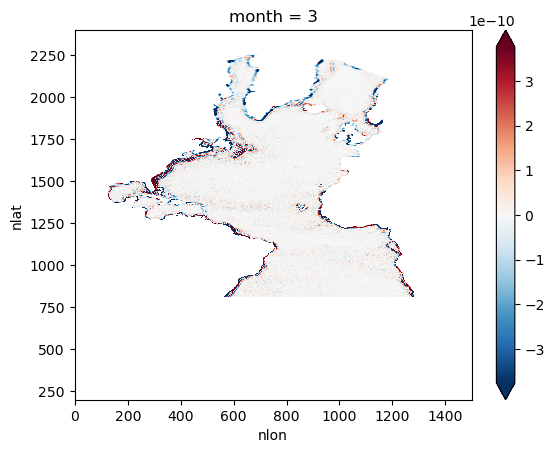

In [23]:
rho_gb.sel(month=3).plot(robust=True)

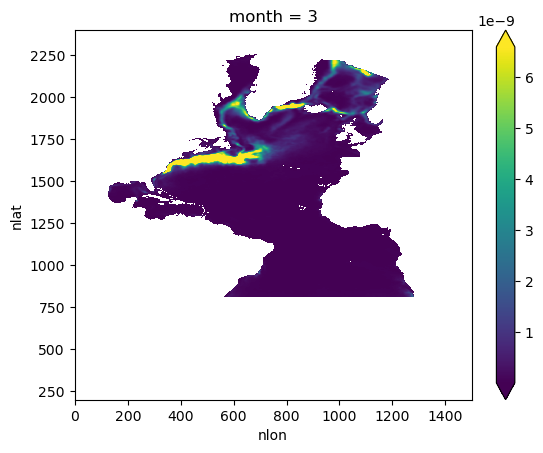

In [24]:
cab_gb.sel(month=3).plot(robust=True)

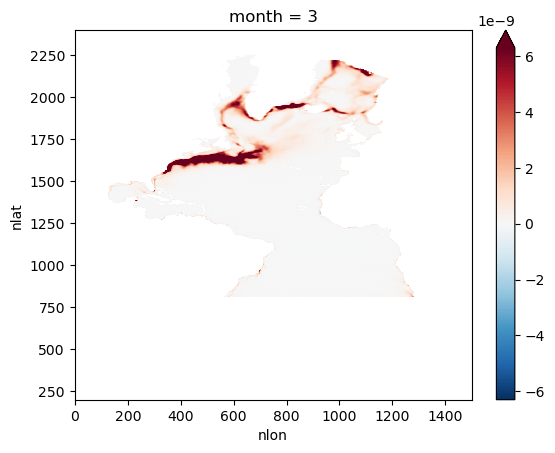

In [25]:
sst_gb.sel(month=3).plot(robust=True)

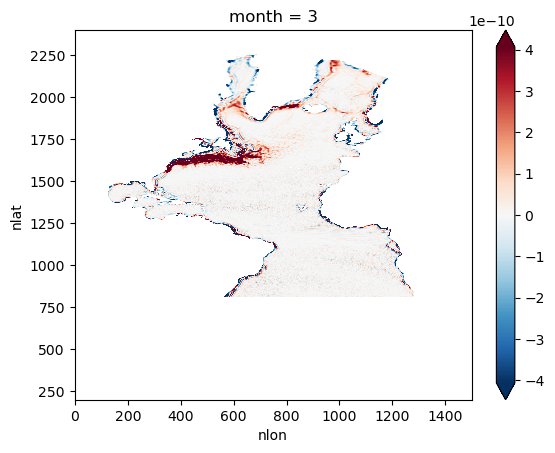

2023-09-06 02:28:21,602 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [27]:
sss_gb.sel(month=3).plot(robust=True)

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,8))

rho_gb.sel(month=3).plot(ax=ax[0,0], robust=True)
ax[0,0].set_title(r'$\frac{D \rho}{D t}$')

sst_gb.sel(month=3).plot(ax=ax[0,1], robust=True)
ax[0,1].set_title('SST')

sss_gb.sel(month=3).plot(ax=ax[1,0], robust=True)
ax[1,0].set_title('SSS')

cab_gb.sel(month=3).plot(ax=ax[1,1], robust=True)
ax[1,1].set_title('cab')

plt.suptitle('Mean March in NATL \n 100km coarse-grained tendency terms', fontsize=16)
plt.tight_layout();

KeyboardInterrupt: 